In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv("~/Downloads/data2.csv")
df.rnd = df.apply(axis=1, func = lambda x: x.n / 2)
df.shape

(14919, 7)

In [3]:
df.head(10)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd
0,9,2,4,1,3.767442,5.232558,4.5
1,9,1,5,0,4.302326,4.697674,4.5
2,9,6,1,4,7.395349,1.604651,4.5
3,9,4,2,3,2.534884,6.465116,4.5
4,9,1,2,0,2.534884,6.465116,4.5
5,9,3,3,2,3.883721,5.116279,4.5
6,9,1,1,0,5.790698,3.209302,4.5
7,9,1,1,0,5.790698,3.209302,4.5
8,14,6,1,2,11.251642,2.748358,7.0
9,14,3,2,1,4.313477,9.686523,7.0


In [4]:
#df['subtree_cnt'] = df.apply(axis=1, func = lambda x: x.subtree_cnt / x.n)
#df['depth'] = df.apply(axis=1, func = lambda x: x.depth / np.log(x.n))
#df['height'] = df.apply(axis=1, func = lambda x: x.height / np.log(x.n))
#df.head(10)

In [5]:
df['alt'] = df.apply(axis=1, func = lambda x: x.hiexpect if x.depth % 2 else x.loexpect)
#df['alt'] = df.apply(axis=1, func = lambda x: x.alt / (x.n-1))
#df['rnd'] = df.apply(axis=1, func = lambda x: x.rnd / (x.n-1))
df.head(15)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt
0,9,2,4,1,3.767442,5.232558,4.5,3.767442
1,9,1,5,0,4.302326,4.697674,4.5,4.697674
2,9,6,1,4,7.395349,1.604651,4.5,1.604651
3,9,4,2,3,2.534884,6.465116,4.5,2.534884
4,9,1,2,0,2.534884,6.465116,4.5,2.534884
5,9,3,3,2,3.883721,5.116279,4.5,5.116279
6,9,1,1,0,5.790698,3.209302,4.5,3.209302
7,9,1,1,0,5.790698,3.209302,4.5,3.209302
8,14,6,1,2,11.251642,2.748358,7.0,2.748358
9,14,3,2,1,4.313477,9.686523,7.0,4.313477


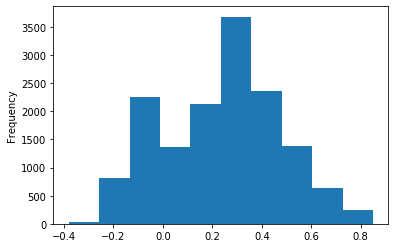

In [6]:
importance = df.apply(axis=1, func = lambda x: (x.rnd-x.alt)/x.rnd)
#df['importance'] = np.power(relerr, 0.5); # TODO
importance.plot(kind="hist");

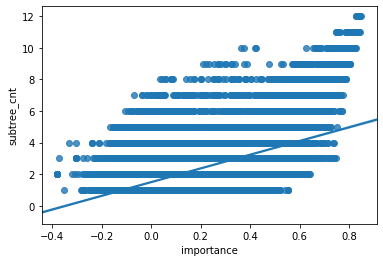

In [7]:
df['importance'] = importance
sns.regplot(x="importance", y="subtree_cnt", data=df);

In [8]:
df['isleaf'] = df.apply(axis=1, func = lambda x: x.height == 0)
df.head(5)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt,importance,isleaf
0,9,2,4,1,3.767442,5.232558,4.5,3.767442,0.162791,False
1,9,1,5,0,4.302326,4.697674,4.5,4.697674,-0.043928,True
2,9,6,1,4,7.395349,1.604651,4.5,1.604651,0.643411,False
3,9,4,2,3,2.534884,6.465116,4.5,2.534884,0.436692,False
4,9,1,2,0,2.534884,6.465116,4.5,2.534884,0.436692,True


In [9]:
posBins = 8;
base = 1.2;
ranges=[]

denom = (np.power(base, posBins) - 1) / (base - 1);
for i in range(0, posBins):
    ranges.insert(0, np.power(base, i)/denom)
for i in range(1, posBins):
    ranges[i] += ranges[i-1]
ranges[-1] = 1.0

print(ranges)

def findBin(x):
    if (x < 0):
        return -1
    for i in range(0, posBins):
        if x < ranges[i]:
            return i
    return np.nan

y = df.importance.apply(findBin)
print("total NA:", y.isna().sum())
print("max importance:", df.importance.max())

[0.21717451867390852, 0.39815328423549895, 0.548968922203491, 0.6746486205101511, 0.7793817024323677, 0.8666592707008817, 0.93939057759131, 1.0]
total NA: 0
max importance: 0.8497098666666666


[0.21717451867390852, 0.39815328423549895, 0.548968922203491, 0.6746486205101511, 0.7793817024323677, 0.8666592707008817]


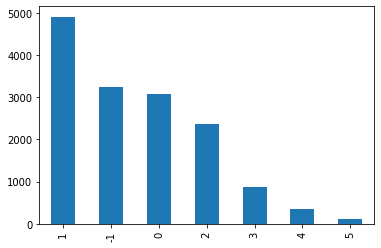

In [10]:
maxBinIdx = y.value_counts().index.max()
posBins = maxBinIdx + 1
ranges = ranges[0:posBins]

print(ranges)

y = df.importance.apply(findBin)
y.value_counts().plot(kind="bar");

In [11]:
X = pd.DataFrame([df.subtree_cnt, df.depth, df.height, df.isleaf, df.n]).transpose()
X.head(5)

,subtree_cnt,depth,height,isleaf,n
0,2,4,1,0,9
1,1,5,0,1,9
2,6,1,4,0,9
3,4,2,3,0,9
4,1,2,0,1,9


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=83)
model = RandomForestClassifier(max_depth=8, n_estimators=200, random_state=82).fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.783358655822683
test score: 0.7729222520107238


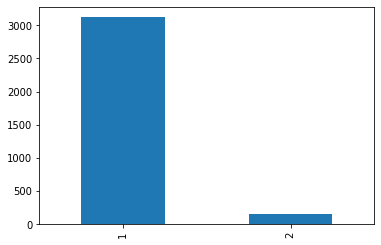

In [13]:
wrongBins = np.abs(model.predict(X)-y)
wrongBins[wrongBins != 0].value_counts().plot(kind="bar");

In [14]:
X_anal = pd.DataFrame([model.predict(X), y]).transpose()
X_anal = X_anal.rename(columns={0: 'predict', 1: 'expected'})
X_anal = pd.concat([df, X_anal], axis=1)

X_anal[wrongBins==3].head(10)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt,importance,isleaf,predict,expected


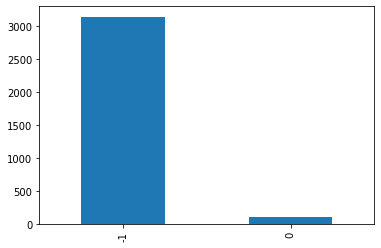

In [15]:
X_anal[X_anal.expected == -1].predict.value_counts().plot(kind = "bar");

In [16]:
X_anal[(X_anal.expected == -1) & (X_anal.predict != -1)].head(15)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt,importance,isleaf,predict,expected
210,12,1,7,0,4.840580,7.159420,6.0,7.159420,-0.193237,True,0,-1
280,11,1,7,0,4.663158,6.336842,5.5,6.336842,-0.152153,True,0,-1
468,15,5,3,4,7.033237,7.966763,7.5,7.966763,-0.062235,False,0,-1
514,12,5,3,4,5.520349,6.479651,6.0,6.479651,-0.079942,False,0,-1
520,12,1,7,0,4.937984,7.062016,6.0,7.062016,-0.177003,True,0,-1
577,13,5,3,4,6.472142,6.527858,6.5,6.527858,-0.004286,False,0,-1
1080,15,7,3,4,7.219311,7.780689,7.5,7.780689,-0.037425,False,0,-1
1369,12,1,7,0,5.599576,6.400424,6.0,6.400424,-0.066737,True,0,-1
1391,12,1,7,0,5.283721,6.716279,6.0,6.716279,-0.119380,True,0,-1
2353,14,7,5,4,6.992495,7.007505,7.0,7.007505,-0.001072,False,0,-1


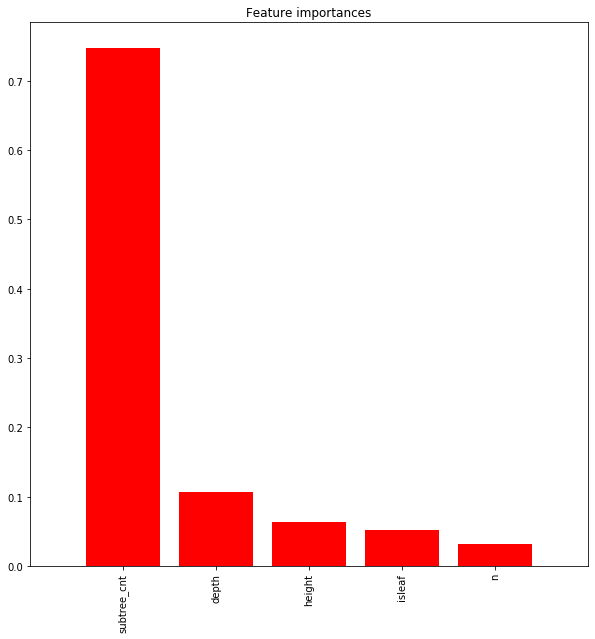

In [17]:
def random_forest_features(model, X, top=-1):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1][:top]
    
    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(indices.size), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(indices.size), X.columns, rotation='vertical')
    plt.xlim([-1, indices.size])
    plt.show()

random_forest_features(model, X, top=20)

In [18]:
#fig = plt.figure(figsize=(5, 15))
#ax1 = fig.add_subplot (6, 1, 1)
#ax2 = fig.add_subplot (6, 1, 2)
#ax3 = fig.add_subplot (6, 1, 3)
#ax4 = fig.add_subplot (6, 1, 4)
#ax5 = fig.add_subplot (6, 1, 5)
#ax6 = fig.add_subplot (6, 1, 6)

#pd.Series(model.predict_proba(X)[:,0])[y==-1].plot(ax=ax1, kind="hist");
#pd.Series(model.predict_proba(X)[:,1])[y==0].plot(ax=ax2, kind="hist");
#pd.Series(model.predict_proba(X)[:,2])[y==1].plot(ax=ax3, kind="hist");
#pd.Series(model.predict_proba(X)[:,3])[y==2].plot(ax=ax4, kind="hist");
#pd.Series(model.predict_proba(X)[:,4])[y==3].plot(ax=ax5, kind="hist");
#pd.Series(model.predict_proba(X)[:,5])[y==4].plot(ax=ax6, kind="hist");

In [19]:
mids = [df.importance[df.importance < 0].mean()]
mids.append(ranges[0] / 2)
for i in range(0, len(ranges)-1):
    mids.append(ranges[i]*0.5 + ranges[i+1]*0.5)
print(mids)

[-0.10332790069792004, 0.10858725933695426, 0.30766390145470374, 0.47356110321949496, 0.611808771356821, 0.7270151614712594, 0.8230204865666246]


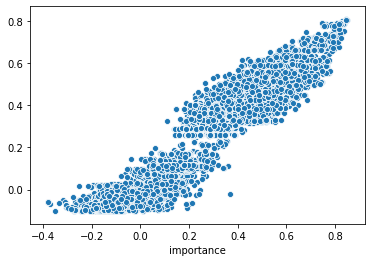

In [20]:
predictImportance = pd.Series(model.predict_proba(X).dot(mids))
sns.scatterplot(df.importance, predictImportance);

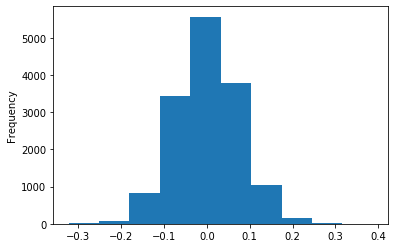

In [27]:
(df.importance-predictImportance).plot(kind="hist");

In [22]:
df['predict'] = predictImportance
df.head(20)

,n,subtree_cnt,depth,height,loexpect,hiexpect,rnd,alt,importance,isleaf,predict
0,9,2,4,1,3.767442,5.232558,4.5,3.767442,0.162791,False,0.141123
1,9,1,5,0,4.302326,4.697674,4.5,4.697674,-0.043928,True,-0.089658
2,9,6,1,4,7.395349,1.604651,4.5,1.604651,0.643411,False,0.603910
3,9,4,2,3,2.534884,6.465116,4.5,2.534884,0.436692,False,0.412538
4,9,1,2,0,2.534884,6.465116,4.5,2.534884,0.436692,True,0.331981
5,9,3,3,2,3.883721,5.116279,4.5,5.116279,-0.136951,False,-0.072273
6,9,1,1,0,5.790698,3.209302,4.5,3.209302,0.286822,True,0.258523
7,9,1,1,0,5.790698,3.209302,4.5,3.209302,0.286822,True,0.258523
8,14,6,1,2,11.251642,2.748358,7.0,2.748358,0.607377,False,0.544376
9,14,3,2,1,4.313477,9.686523,7.0,4.313477,0.383789,False,0.387849


In [23]:
from sklearn.externals import joblib

joblib.dump(model, 'predict.model');